# Assignment #7
### Gagana Uday Kumar (WOV796)

### 3.Consider the Gini index, classification error, and entropy in a simple classification setting with two classes. Create a single plot that displays each of these quantities as a function of ˆpm1. The x-axis should display ˆpm1, ranging from 0 to 1, and the y-axis should display the value of the Gini index, classification error, and entropy. Hint: In a setting with two classes, ˆpm1 = 1 − ˆpm2. You could make this plot by hand, but it will be much easier to make in R.

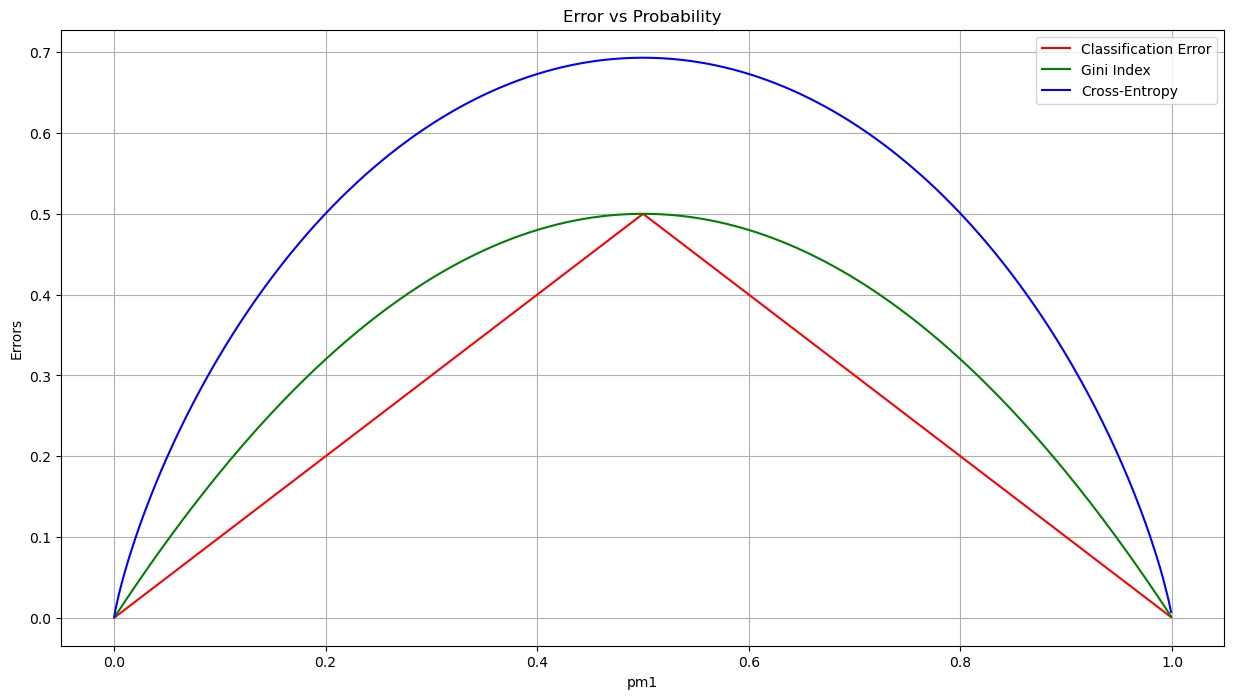

In [84]:
import numpy as np
import matplotlib.pyplot as plt

pm1 = np.random.uniform(0.0, 1.0, 1000)
pm2 = 1 - pm1
E = 1 - np.maximum(pm1, pm2)
G = np.add(np.multiply(pm1, pm2), np.multiply(pm1, pm2))
D = np.add(-pm1 * np.log(pm1), -pm2 * np.log(pm2))

E_dict = {}
G_dict = {}
D_dict = {}
for idx, pm in enumerate(pm1):
    E_dict[pm] = E[idx]
    G_dict[pm] = G[idx]
    D_dict[pm] = D[idx]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

lists = sorted(E_dict.items())
x, y = zip(*lists)
plt.plot(x, y, color='r', label='Classification Error')

lists = sorted(G_dict.items())
x, y = zip(*lists)
plt.plot(x, y, color='g', label='Gini Index')

lists = sorted(D_dict.items())
x, y = zip(*lists)
plt.plot(x, y, color='b', label='Cross-Entropy')

ax.set_xlabel('pm1')
ax.set_ylabel('Errors')
ax.set_title('Error vs Probability')

plt.legend()
plt.grid()
plt.show()

### 8. In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.



In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [86]:
carseats = pd.read_csv('carseats.csv',na_values=['?']).dropna()
carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [87]:
carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


### (a) Split the data set into a training set and a test set.


In [88]:
carseats['US'] = carseats['US'].map({'Yes': 1, 'No': 0})
carseats['Urban'] = carseats['Urban'].map({'Yes': 1, 'No': 0})
carseats = pd.get_dummies(carseats, prefix=['ShelveLoc'])
#carseats = carseats.rename(columns={'Unnamed: 0': 'Id'})

carseats.head()


,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium
0,9.50,138,73,11,276,120,42,17,1,1,1,0,0
1,11.22,111,48,16,260,83,65,10,1,1,0,1,0
2,10.06,113,35,10,269,80,59,12,1,1,0,0,1
3,7.40,117,100,4,466,97,55,14,1,1,0,0,1
4,4.15,141,64,3,340,128,38,13,1,0,1,0,0


In [89]:
carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales             400 non-null    float64
 1   CompPrice         400 non-null    int64  
 2   Income            400 non-null    int64  
 3   Advertising       400 non-null    int64  
 4   Population        400 non-null    int64  
 5   Price             400 non-null    int64  
 6   Age               400 non-null    int64  
 7   Education         400 non-null    int64  
 8   Urban             400 non-null    int64  
 9   US                400 non-null    int64  
 10  ShelveLoc_Bad     400 non-null    uint8  
 11  ShelveLoc_Good    400 non-null    uint8  
 12  ShelveLoc_Medium  400 non-null    uint8  
dtypes: float64(1), int64(9), uint8(3)
memory usage: 32.6 KB


In [90]:
# Splitting the data into features (X) and the target variable (y)
X = carseats.drop('Sales', axis=1)
y = carseats['Sales']

# Splitting the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### (b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?


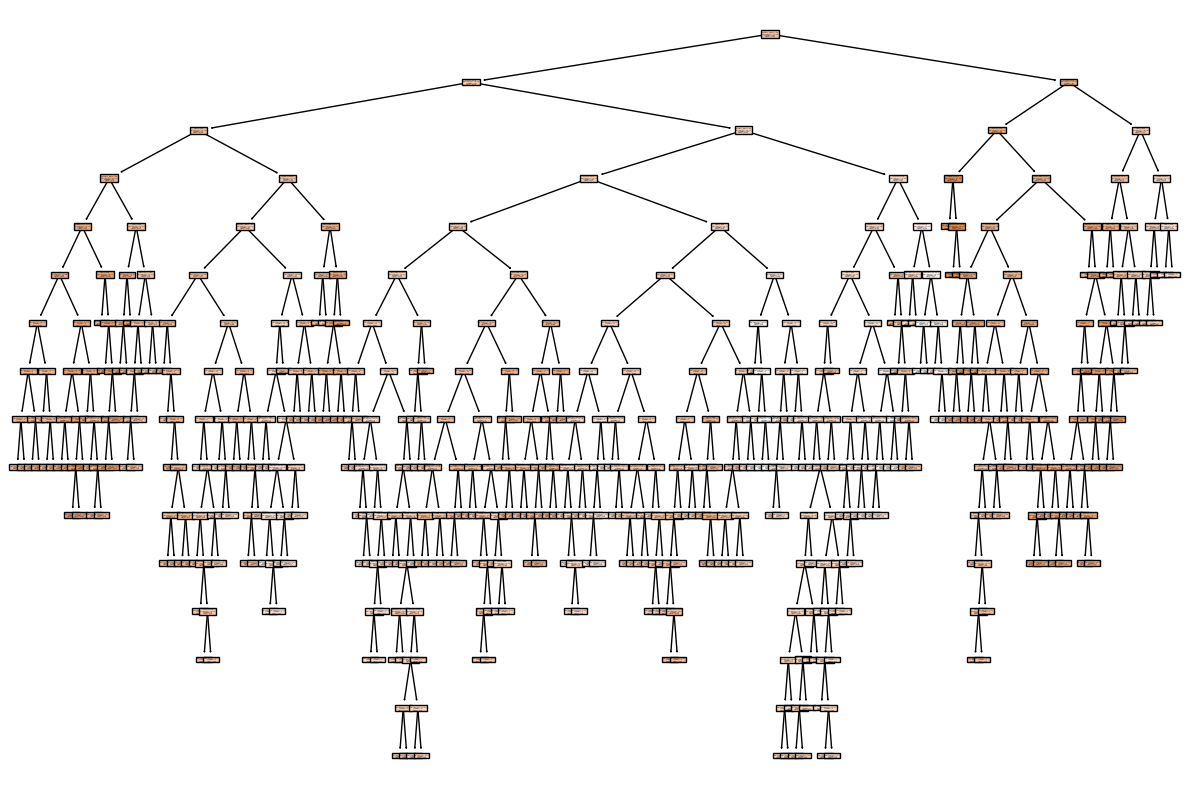

In [91]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Fit a regression tree to the training set
reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train, y_train)

# Plotting the tree
plt.figure(figsize=(15, 10))
plot_tree(reg_tree, filled=True, feature_names=X.columns)
plt.show()

In [92]:
from sklearn.metrics import mean_squared_error

# Predicting on the test set
y_pred = reg_tree.predict(X_test)

# Calculating the test MSE
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)

Test MSE: 4.617658333333334


### (c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?


In [93]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Define a function to compute the cross-validation scores
def cross_val_mse(model, X, y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10)
    return -scores.mean()

# Create a range of tree depths to test
depths = np.arange(1, 21)

# Initialize lists to store mean MSE scores
mean_mse_scores = []
pruned_mean_mse_scores = []

# Iterate over different tree depths
for depth in depths:
    # Create decision tree regressor with current depth
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Compute mean MSE score using cross-validation
    mean_mse = cross_val_mse(tree_reg, X_train, y_train)
    mean_mse_scores.append(mean_mse)
    
    # Pruning the tree manually by limiting max_depth
    pruned_tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    pruned_mean_mse = cross_val_mse(pruned_tree_reg, X_train, y_train)
    pruned_mean_mse_scores.append(pruned_mean_mse)

# Find the optimal tree depth
optimal_depth = depths[np.argmin(mean_mse_scores)]
print("Optimal Tree Depth (without pruning):", optimal_depth)
print("MSE (without pruning):", mean_mse_scores[optimal_depth-1])

optimal_pruned_depth = depths[np.argmin(pruned_mean_mse_scores)]
print("Optimal Tree Depth (with pruning):", optimal_pruned_depth)
print("MSE (with pruning):", pruned_mean_mse_scores[optimal_pruned_depth-1])

Optimal Tree Depth (without pruning): 6
MSE (without pruning): 4.5634783794332305
Optimal Tree Depth (with pruning): 6
MSE (with pruning): 4.5634783794332305


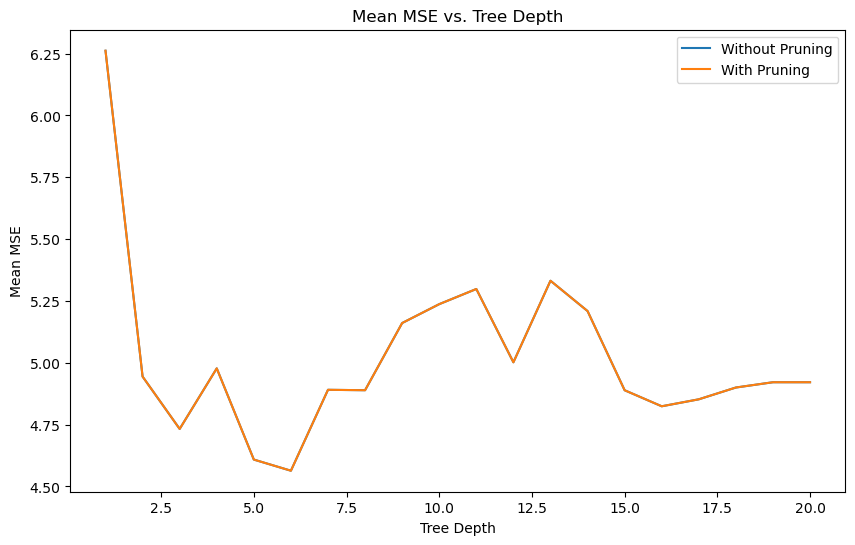

In [94]:
# Plotting the mean MSE scores for different tree depths
plt.figure(figsize=(10, 6))
plt.plot(depths, mean_mse_scores, label='Without Pruning')
plt.plot(depths, pruned_mean_mse_scores, label='With Pruning')
plt.xlabel('Tree Depth')
plt.ylabel('Mean MSE')
plt.title('Mean MSE vs. Tree Depth')
plt.legend()
plt.show()


The results that has been shared indicate that the optimal tree depth remains the same whether or not you use pruning. Additionally, the mean squared error (MSE) on the test set remains the same for both the pruned and unpruned trees. This suggests that pruning the decision tree does not seem to improve the test MSE in your case.

### (d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the feature_importance_ values to determine which variables are most important.


In [96]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

# Initialize the BaggingRegressor
bagging_reg = BaggingRegressor(random_state=42)

# Fit the BaggingRegressor on the training data
bagging_reg.fit(X_train, y_train)

# Predict on the test data
y_pred_bagging = bagging_reg.predict(X_test)

# Calculate the test MSE
test_mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print("Test MSE (Bagging):", test_mse_bagging)

Test MSE (Bagging): 2.8438797166666663


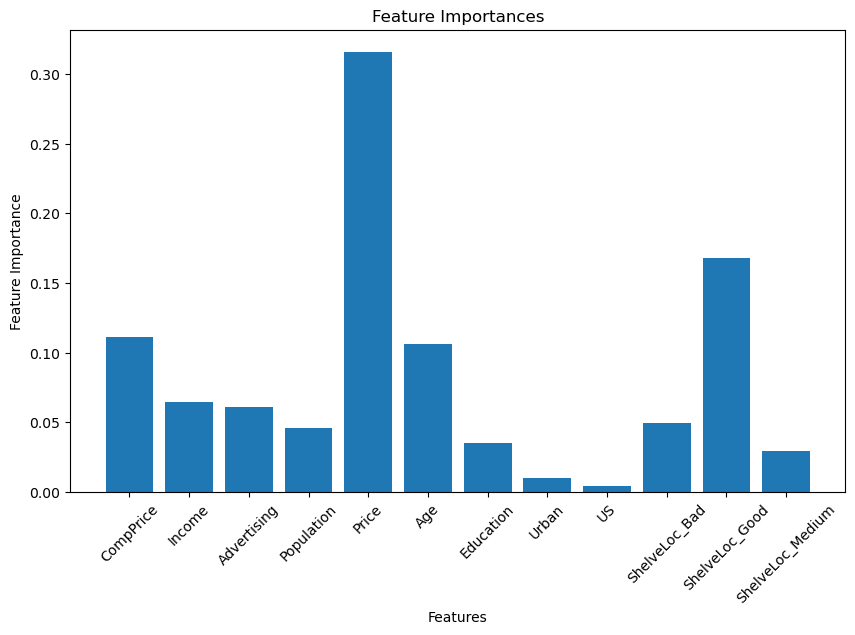

In [97]:
import matplotlib.pyplot as plt

# Calculate feature importances
feature_importances = np.mean([tree.feature_importances_ for tree in bagging_reg.estimators_], axis=0)

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns.tolist(), feature_importances)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

The variable most important is Price followed by ShelveLoc_Good

### (e) Use random forests to analyze this data. What test MSE do you obtain? Use the feature_importance_ values to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.


In [98]:
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)

y_pred_rf = random_forest.predict(X_test)

test_mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Test MSE (Random Forest):", test_mse_rf)

Test MSE (Random Forest): 2.5044488375


In [99]:
feature_importances_rf = random_forest.feature_importances_
print("Feature Importances (Random Forest):", feature_importances_rf)

Feature Importances (Random Forest): [0.10206146 0.0553432  0.0724988  0.04000349 0.30998688 0.12615268
 0.02910049 0.008265   0.00607926 0.05312568 0.17599618 0.02138687]


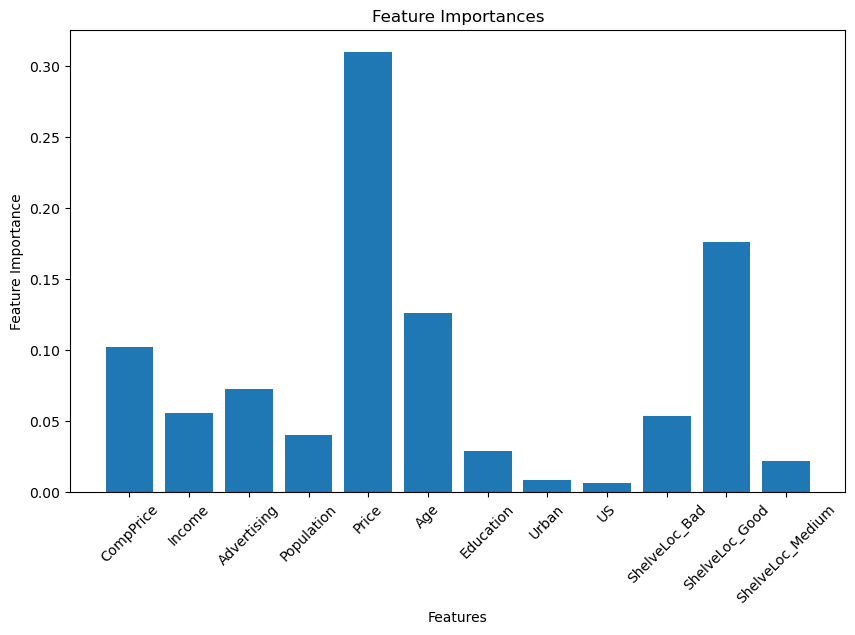

In [100]:
import matplotlib.pyplot as plt

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns.tolist(), feature_importances_rf)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

The variable most important is Price followed by ShelveLoc_Good

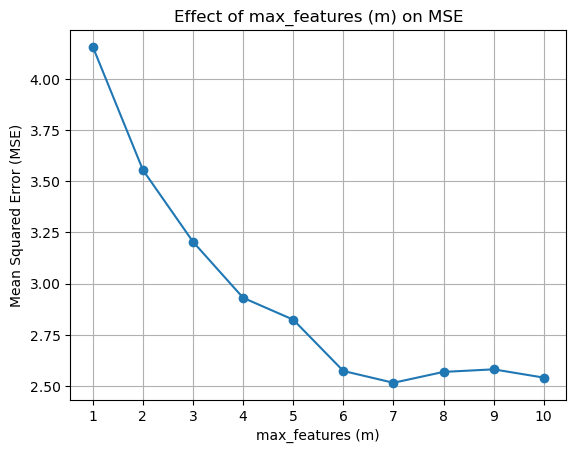

In [101]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define a range of values for m
m_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize lists to store MSE values
mse_values = []

# Fit Random Forest models for different values of m
for m in m_values:
    # Initialize Random Forest regressor with specified m
    rf_reg = RandomForestRegressor(n_estimators=100, max_features=m, random_state=42)
    
    # Fit the model on the training data
    rf_reg.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred_rf = rf_reg.predict(X_test)
    
    # Calculate MSE and store it
    mse = mean_squared_error(y_test, y_pred_rf)
    mse_values.append(mse)

# Plot the effect of m on MSE
plt.plot(m_values, mse_values, marker='o')
plt.title('Effect of max_features (m) on MSE')
plt.xlabel('max_features (m)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(m_values)
plt.grid(True)
plt.show()

### (f) Now analyze the data using BART, and report your results.

In [102]:
from ISLP.bart import BART


In [104]:
import numpy as np
import pandas as pd

# Assuming X_train, X_test, y_train, y_test are already defined as Pandas dataframes
# Convert data to numpy arrays and ensure they are of the appropriate data type
X_train_np = X_train.apply(pd.to_numeric, errors='coerce').values
X_test_np = X_test.apply(pd.to_numeric, errors='coerce').values
y_train_np = y_train.apply(pd.to_numeric, errors='coerce').values
y_test_np = y_test.apply(pd.to_numeric, errors='coerce').values

# Check if there are any NaN values in the data and handle them as needed
X_train_np = np.nan_to_num(X_train_np)
X_test_np = np.nan_to_num(X_test_np)
y_train_np = np.nan_to_num(y_train_np)
y_test_np = np.nan_to_num(y_test_np)

# Continue with your BART model
from ISLP.bart import BART

# Initialize the BART model
bart_model = BART()

# Fit the model
bart_model.fit(X_train_np, y_train_np)

# Make predictions
y_pred_bart = bart_model.predict(X_test_np)

# Calculate the mean squared error
mse_bart = mean_squared_error(y_test_np, y_pred_bart)
print(f"Test MSE (BART): {mse_bart}")


Test MSE (BART): 1.425936332016126


### 9. This problem involves the OJ data set which is part of the ISLP package.


In [44]:
oj = pd.read_csv('OJ.csv',na_values=['?']).dropna()
oj

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,CH,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,Yes,0.000000,0.053763,0.23,0
1066,CH,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1067,MM,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1068,CH,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,Yes,0.112676,0.000000,0.27,0


In [45]:
oj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Purchase        1070 non-null   object 
 1   WeekofPurchase  1070 non-null   int64  
 2   StoreID         1070 non-null   int64  
 3   PriceCH         1070 non-null   float64
 4   PriceMM         1070 non-null   float64
 5   DiscCH          1070 non-null   float64
 6   DiscMM          1070 non-null   float64
 7   SpecialCH       1070 non-null   int64  
 8   SpecialMM       1070 non-null   int64  
 9   LoyalCH         1070 non-null   float64
 10  SalePriceMM     1070 non-null   float64
 11  SalePriceCH     1070 non-null   float64
 12  PriceDiff       1070 non-null   float64
 13  Store7          1070 non-null   object 
 14  PctDiscMM       1070 non-null   float64
 15  PctDiscCH       1070 non-null   float64
 16  ListPriceDiff   1070 non-null   float64
 17  STORE           1070 non-null   i

In [46]:
oj['Store7'].unique()

array(['No', 'Yes'], dtype=object)

In [47]:
#oj['Store7'] = oj['Store7'].map({'Yes': 1, 'No': 0})

oj['Store7'] = oj['Store7'].replace({'Yes': 1, 'No': 0})
oj.describe()

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,254.381308,3.959813,1.867421,2.085411,0.051860,0.123364,0.147664,0.161682,0.565782,1.962047,1.815561,0.146486,0.332710,0.059298,0.027314,0.217991,1.630841
std,15.558286,2.308984,0.101970,0.134386,0.117474,0.213834,0.354932,0.368331,0.307843,0.252697,0.143384,0.271563,0.471404,0.101760,0.062232,0.107535,1.430387
min,227.000000,1.000000,1.690000,1.690000,0.000000,0.000000,0.000000,0.000000,0.000011,1.190000,1.390000,-0.670000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,240.000000,2.000000,1.790000,1.990000,0.000000,0.000000,0.000000,0.000000,0.325257,1.690000,1.750000,0.000000,0.000000,0.000000,0.000000,0.140000,0.000000
50%,257.000000,3.000000,1.860000,2.090000,0.000000,0.000000,0.000000,0.000000,0.600000,2.090000,1.860000,0.230000,0.000000,0.000000,0.000000,0.240000,2.000000
75%,268.000000,7.000000,1.990000,2.180000,0.000000,0.230000,0.000000,0.000000,0.850873,2.130000,1.890000,0.320000,1.000000,0.112676,0.000000,0.300000,3.000000
max,278.000000,7.000000,2.090000,2.290000,0.500000,0.800000,1.000000,1.000000,0.999947,2.290000,2.090000,0.640000,1.000000,0.402010,0.252688,0.440000,4.000000


### (a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.


In [48]:
#X = oj.drop(['Purchase'])
#y = oj['Purchase']
#X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=800, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(oj.drop(['Purchase'], axis=1), oj['Purchase'], train_size=800, random_state=42)


### (b) Fit a tree to the training data, with Purchase as the response and the other variables as predictors. What is the training error rate?


In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(random_state=0, min_samples_split=100)
clf.fit(X_train, y_train)

training_error_rate = 1 - clf.score(X_train, y_train)
print("Training Error rate:", training_error_rate)

Training Error rate: 0.15500000000000003


### (c) Create a plot of the tree, and interpret the results. How many terminal nodes does the tree have?


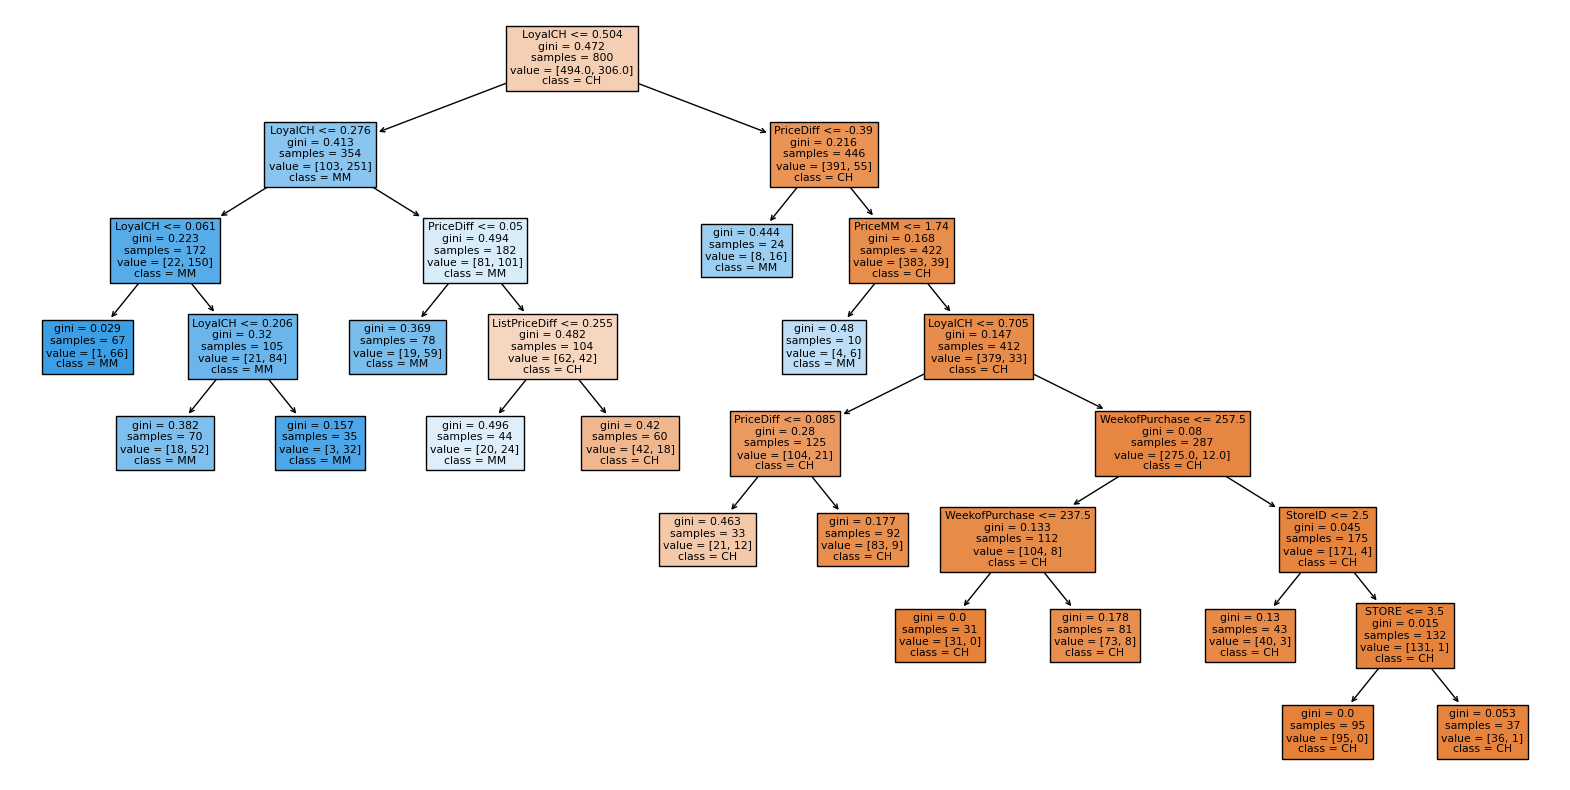

Number of terminal nodes: 15


In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=clf.classes_)
plt.show()

# Get the number of terminal nodes
n_terminal_nodes = clf.tree_.n_leaves
print("Number of terminal nodes:", n_terminal_nodes)


### (d) Use the export_tree() function to produce a text summary of the fitted tree. Pick one of the terminal nodes, and interpret the information displayed.


In [51]:
from sklearn.tree import export_text

# Export the fitted tree as text
tree_text = export_text(clf, feature_names=X_train.columns.tolist())

# Print the text summary of the tree
print(tree_text)

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- class: MM
|   |   |--- LoyalCH >  0.06
|   |   |   |--- LoyalCH <= 0.21
|   |   |   |   |--- class: MM
|   |   |   |--- LoyalCH >  0.21
|   |   |   |   |--- class: MM
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- class: MM
|   |   |--- PriceDiff >  0.05
|   |   |   |--- ListPriceDiff <= 0.26
|   |   |   |   |--- class: MM
|   |   |   |--- ListPriceDiff >  0.26
|   |   |   |   |--- class: CH
|--- LoyalCH >  0.50
|   |--- PriceDiff <= -0.39
|   |   |--- class: MM
|   |--- PriceDiff >  -0.39
|   |   |--- PriceMM <= 1.74
|   |   |   |--- class: MM
|   |   |--- PriceMM >  1.74
|   |   |   |--- LoyalCH <= 0.71
|   |   |   |   |--- PriceDiff <= 0.09
|   |   |   |   |   |--- class: CH
|   |   |   |   |--- PriceDiff >  0.09
|   |   |   |   |   |--- class: CH
|   |   |   |--- LoyalCH >  0.71
|   |   |   |   |--- WeekofPurchase <= 257.50
|   |   |   |   |   |--- WeekofPurchase <=

Interpretation:

This terminal node is reached when the value of LoyalCH is greater than 0.71.
Within this node, further decisions are made based on the value of WeekofPurchase and StoreID.
If WeekofPurchase is less than or equal to 257.50 and StoreID is greater than 2.50, the predicted class is "CH".
Otherwise, if WeekofPurchase is less than or equal to 237.50, the predicted class is "CH".
If none of the above conditions are met, the predicted class is also "CH".

### (e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?


In [52]:
from sklearn.metrics import confusion_matrix


# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the test error rate
test_error_rate = 1 - accuracy_score(y_pred, y_test)
print("Test Error rate is:", test_error_rate)

Confusion Matrix:
[[126  33]
 [ 33  78]]
Test Error rate is: 0.24444444444444446


### (f) Use cross-validation on the training set in order to determine the optimal tree size.


In [65]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define a range of tree sizes (max_depths)
tree_sizes = range(1, 21)

# Initialize an empty list to store cross-validation scores
cv_scores = []

# Iterate over each tree size
for size in tree_sizes:
    # Initialize DecisionTreeClassifier with the current tree size
    clf = DecisionTreeClassifier(max_depth=size, random_state=0)
    
    # Perform cross-validation and compute mean cross-validation score
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    cv_scores.append(np.mean(scores))

# Find the tree size with the highest mean cross-validation score
optimal_tree_size = tree_sizes[np.argmax(cv_scores)]
optimal_cv_score = max(cv_scores)

print("Optimal tree size:", optimal_tree_size)
print("Mean cross-validation score for optimal tree size:", optimal_cv_score)



Optimal tree size: 4
Mean cross-validation score for optimal tree size: 0.83375


### (g) Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.


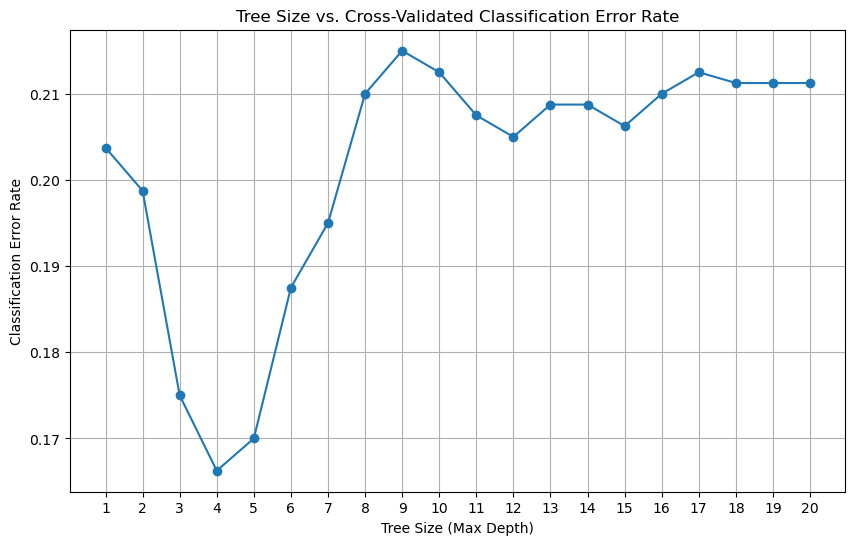

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Define a range of tree sizes (max depth)
tree_sizes = range(1, 21)

# Initialize an empty list to store classification error rates
error_rates = []

# Iterate over each tree size
for size in tree_sizes:
    # Initialize DecisionTreeClassifier with the current tree size
    clf = DecisionTreeClassifier(max_depth=size, random_state=0)
    
    # Perform cross-validation and compute classification error rate
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    error_rate = 1 - np.mean(scores)  # Classification error rate
    error_rates.append(error_rate)

# Plot tree size vs. classification error rate
plt.figure(figsize=(10, 6))
plt.plot(tree_sizes, error_rates, marker='o')
plt.title('Tree Size vs. Cross-Validated Classification Error Rate')
plt.xlabel('Tree Size (Max Depth)')
plt.ylabel('Classification Error Rate')
plt.xticks(tree_sizes)
plt.grid(True)
plt.show()


### (h) Which tree size corresponds to the lowest cross-validated classification error rate?


In [67]:
# Find the index of the minimum error rate
min_error_index = np.argmin(error_rates)

# Corresponding tree size (max depth)
best_tree_size = tree_sizes[min_error_index]

print("Tree size with the lowest cross-validated classification error rate:", best_tree_size)

Tree size with the lowest cross-validated classification error rate: 4


### (i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.


In [68]:
from sklearn.tree import DecisionTreeClassifier

# Create a pruned tree with the optimal tree size obtained from cross-validation
print("Optimal tree size:", optimal_tree_size)
pruned_tree = DecisionTreeClassifier(max_depth=optimal_tree_size)
pruned_tree.fit(X_train, y_train)

# Check if the tree has the desired number of terminal nodes (pruning)
n_terminal_nodes = pruned_tree.tree_.n_leaves
print("Number of terminal nodes:", n_terminal_nodes)
if n_terminal_nodes != 5:
    print("The tree does not have 5 terminal nodes. Creating a pruned tree with max_depth=5.")
    # If the tree doesn't have 5 terminal nodes, create a pruned tree with max_depth=5
    pruned_tree = DecisionTreeClassifier(max_depth=5)
    pruned_tree.fit(X_train, y_train)


Optimal tree size: 4
Number of terminal nodes: 16
The tree does not have 5 terminal nodes. Creating a pruned tree with max_depth=5.


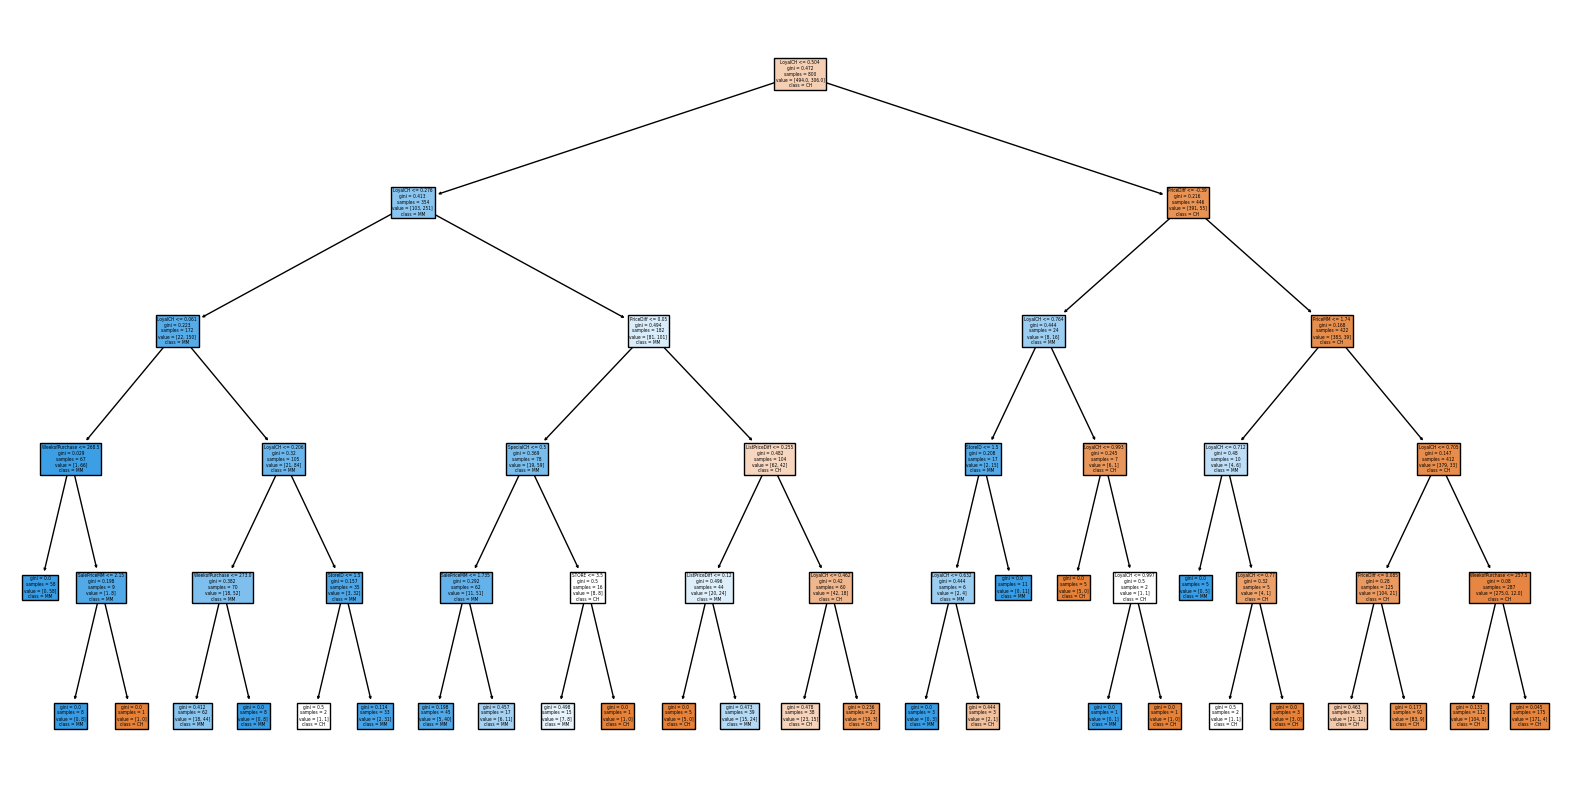

In [81]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the pruned decision tree
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, filled=True, feature_names=X_train.columns, class_names=pruned_tree.classes_)
plt.show()



### (j) Compare the training error rates between the pruned and unpruned trees. Which is higher?


In [82]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#clf = DecisionTreeClassifier(random_state=0, min_samples_split=100)
#clf.fit(X_train, y_train)

#training_error_rate = 1 - clf.score(X_train, y_train)
print("Training Error rate(Unpruned tree):", training_error_rate)

# Calculate training error rate for pruned tree
pruned_training_error_rate = 1 - pruned_tree.score(X_train, y_train)
print("Training Error rate (Pruned tree):", pruned_training_error_rate)

# Compare training error rates
if  training_error_rate > pruned_training_error_rate:
    print("The training error rate of the unpruned tree is higher.")
elif  training_error_rate < pruned_training_error_rate:
    print("The training error rate of the pruned tree is higher.")
else:
    print("The training error rates of the unpruned and pruned trees are equal.")

Training Error rate(Unpruned tree): 0.15500000000000003
Training Error rate (Pruned tree): 0.13375000000000004
The training error rate of the unpruned tree is higher.


### (k) Compare the test error rates between the pruned and unpruned trees. Which is higher?

In [83]:
# Calculate test error rate for unpruned tree (already created from previous code)
#unpruned_test_error_rate = 1 - accuracy_score(classifier.predict(X_test), y_test)
#print("Test Error rate (Unpruned tree):", unpruned_test_error_rate)
print("Test Error rate (Unpruned tree):", test_error_rate)

# Calculate test error rate for pruned tree (already created from previous code)
pruned_test_error_rate = 1 - pruned_tree.score(X_test, y_test)
print("Test Error rate (Pruned tree):", pruned_test_error_rate)

if test_error_rate > pruned_test_error_rate:
    print("The test error rate of the unpruned tree is higher.")
elif test_error_rate < pruned_test_error_rate:
    print("The test error rate of the pruned tree is higher.")
else:
    print("The test error rates of the unpruned and pruned trees are equal.")

Test Error rate (Unpruned tree): 0.24444444444444446
Test Error rate (Pruned tree): 0.2592592592592593
The test error rate of the pruned tree is higher.
